### Hydrate Formation Calculation
#### Zach Murphy, 4-18-2022

In [1]:
#imports
import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import gas_density as rho_g_fun # Temp IN C and Pressure in PSI
%matplotlib inline

In [2]:
# IMPORT DATA
df=pd.read_excel('ST140_formation.xlsx')
df['P avg']=(df['P up']+df['P down'])/2

In [3]:
Stability=6.8

In [4]:
# Density
df['rho_g_m'],df['Z']=rho_g_fun.CH4_EOS(df['T'],df['P avg']) #density (mol/m3) and Z
rho_h=912*1000/124+(912*1000/124)*5.75 #density of hydrate (mol/m^3)
rho_l=1027.6*1000/18.02 #(mol/m^3)  #1027.6 #kg/m^3 # !ASSUME TO BE CONSTANT BUT CAN ADD FUCTION TO UPDATE!

In [5]:
# Core Parameters
L=7.62 #sample length (m)
r=0.00493/2 #sample radius (m)
A=m.pi*r**2 #sample area (m^2)
V_sample=A*L #sample volume (m^3)
por=.39 #sample porosity (-)
Vp=V_sample*por #sample pore volume (m^3)
Vp_ml=Vp*10**6
V_line=5 #volume of lines, fittings, etc
R=8.314 #gas constants (Pa m^3)/(mol k)
BPR=825 #BPR set pressure

In [6]:
# Known Constants
Xwg=0; Xmg=1 #mass fractions in gas phase (gas is pure methane) 
Xmh=0.17; Xwh=0.83  #mol fractions in hydrate phase
Xml=0.00; Xwl=1-Xml

In [7]:
# Initial Conditions
Sli=0.7 #intial liquid saturation
Sgi=0.3 # initial gas saturation
Shi=0 #initial hydrate saturation

In [8]:
#  Initial Moles
mWi=(Xwl*Sli*rho_l+Xwh*Shi*rho_h)*Vp #mols of h2o
mGi=(Xml*Sli*rho_l+Xmg*Sgi*df['rho_g_m'][0]+Xmh*Shi*rho_h)*Vp #mols of ch4

In [9]:
# mol in and mol out each time step
df['mGas in']=(df['Gas in']*0.000001)*df['rho_g_m'] #ml at reservoir conditions to mol gas
df['mGas out']=(df['Gas out']*0.000001)*df['rho_g_m'] #mol gas out

df['mWater in']=df['Water in']*.000001*rho_l*Xwl #mol water in
df['mWater out']=df['Water out']*.000001*rho_l*Xwl #mol water out

df['deltamG']=df['mGas in'].diff()-df['mGas out'].diff() #change in mass of gas in system (kg)
df['deltamW']=df['mWater in'].diff()-df['mWater out'].diff() #change in mass of water in system (kg)

df=df.fillna(0)

df['mGAS']=mGi+df['deltamG'].cumsum() #mol of gas
df['mH2O']=mWi+df['deltamW'].cumsum() #mol of water

In [10]:
# Matrix to solve for Saturation
sat=pd.DataFrame(columns=['time','Sl','Sg','Sh'])
for i,row in df.iterrows():
    A=np.array([[1, 1, 1],
                [Xwl*rho_l, Xwg*df['rho_g_m'][i],Xwh*rho_h],
                [Xml*rho_l, Xmg*df['rho_g_m'][i], Xmh*rho_h]]) 
   
    B=np.array([1,df['mH2O'][i]/Vp,df['mGAS'][i]/Vp])
    X=np.linalg.solve(A,B)
    
    sat=sat.append({'Sh':X[2],'Sg':X[1],'Sl':X[0],'time':df['time'][i]},ignore_index=True)

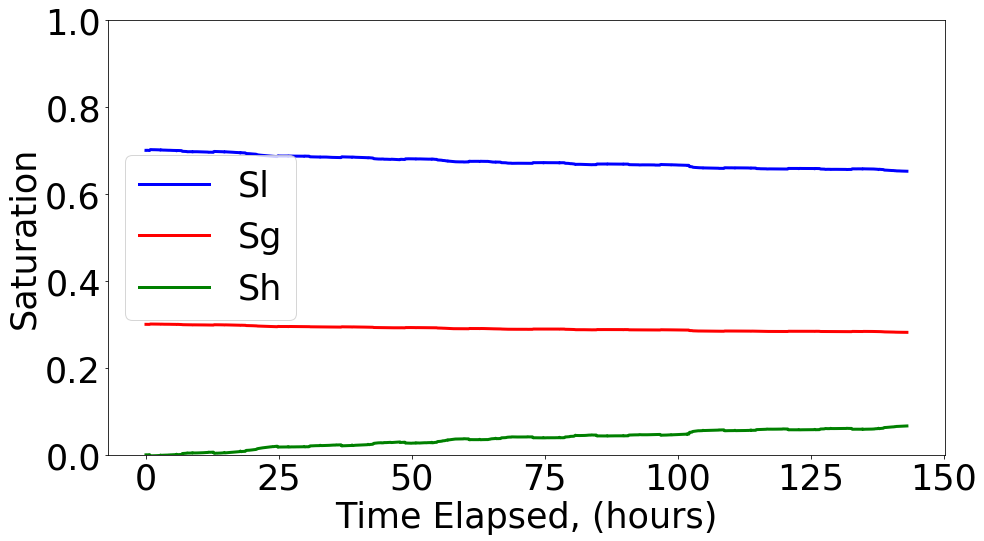

In [12]:
# Saturation vs Time
plt.figure(figsize=(15,8))
plt.rcParams['font.size']=35

plt.plot(sat['time'],sat['Sl'],label='Sl',linewidth=3,color='blue')
plt.plot(sat['time'],sat['Sg'],label='Sg',linewidth=3,color='red')
plt.plot(sat['time'],sat['Sh'],label='Sh',linewidth=3,color='green')
#plt.plot(sat['time'],sat['Sh']+sat['Sl']+sat['Sg'],label='sum',linewidth=3,color='black')


plt.xlabel('Time Elapsed, (hours)')
#plt.xlim([0,5])

plt.ylim([0,1])
plt.ylabel('Saturation')
plt.legend(loc='best')

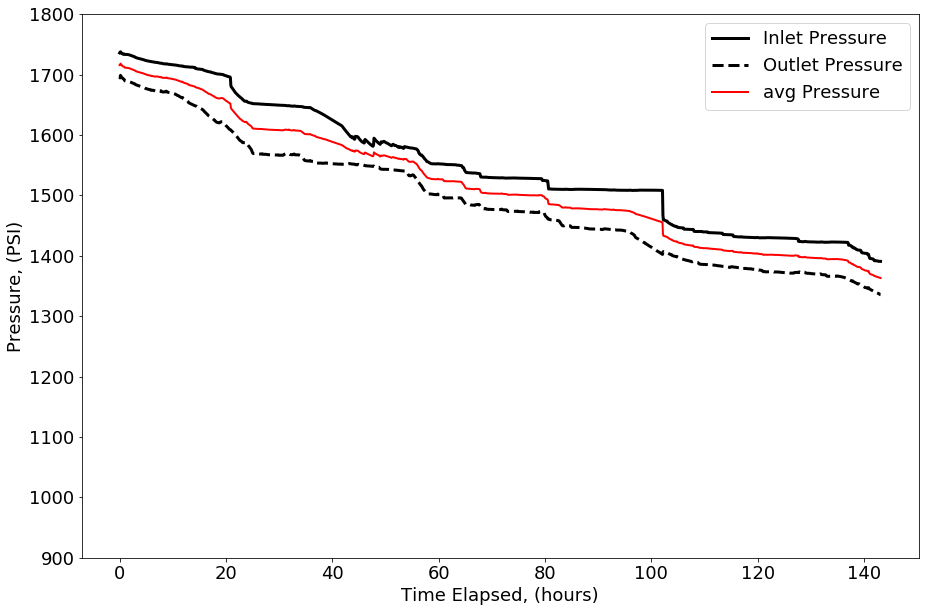

In [13]:
fig=plt.figure(figsize=(15,10))
plt.rcParams['font.size']=18
sharex='True'

plt1=fig.add_subplot(1,1,1)
plt1.plot(df['time'],df['P up'],label='Inlet Pressure',linewidth=3,color='black')
plt1.plot(df['time'],df['P down'],label='Outlet Pressure',linewidth=3,color='black',linestyle='dashed')
plt1.plot(df['time'],df['P avg'],label='avg Pressure',linewidth=2,color='red')
#plt.xlim([0,200])
plt.xlabel('Time Elapsed, (hours)')
plt.ylim([900,1800])
plt.ylabel('Pressure, (PSI)')
plt.legend(loc='best')

#plt2=fig.add_subplot(2,1,2,sharex=plt1)
#plt2.plot(df['time'],df['Gas in'],label='Gas In',linewidth=3,color='black')
#plt2.plot(df['time'],df['Gas out'],label='Gas Out',linewidth=3,color='black',linestyle='dashed')
#plt.xlim([800,1005])
#plt.xlabel('Time Elapsed, (hours)')
#plt.ylim([900,1400])
#plt.ylabel('Volume, (mL @ reservoir conditions)')
#plt.legend(loc='best')
#plt.title(' Gas in * 0.82', y=.9)

#plt.legend(loc='best')